# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

In [ ]:
from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

In [ ]:
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [ ]:
print(X_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

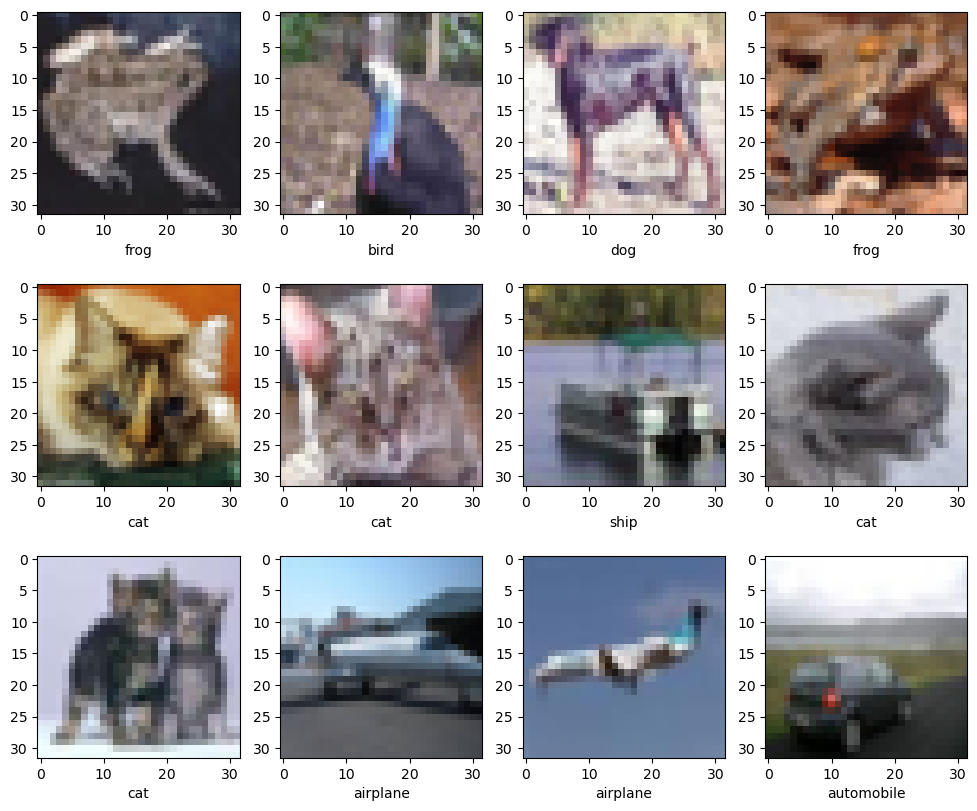

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) **от 0 до 255**. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон **`[0, 1]`** — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), 'Data shape should not change'
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255)) > 10, 'Make sure you casted data to float type'

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. Принимает на вход картинки размера 32 x 32 x 3;
2. Вытягивает их в вектор (`keras.layers.Flatten`);
3. Пропускает через 1 или 2 полносвязных слоя;
4. Выходной слой отдаёт вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print('Успех!')

1/1 [==============================] - 0s 193ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 11s 5ms/step - loss: 1.9463 - accuracy: 0.2947 - val_loss: 1.7326 - val_accuracy: 0.3804
Epoch 2/32
2000/2000 [==============================] - 10s 5ms/step - loss: 1.6880 - accuracy: 0.3965 - val_loss: 1.6376 - val_accuracy: 0.4106
Epoch 3/32
2000/2000 [==============================] - 10s 5ms/step - loss: 1.5794 - accuracy: 0.4391 - val_loss: 1.5511 - val_accuracy: 0.4444
Epoch 4/32
2000/2000 [==============================] - 11s 5ms/step - loss: 1.5139 - accuracy: 0.4603 - val_loss: 1.5172 - val_accuracy: 0.4627
Epoch 5/32
2000/2000 [==============================] - 10s 5ms/step - loss: 1.4654 - accuracy: 0.4772 - val_loss: 1.5226 - val_accuracy: 0.4595
Epoch 6/32
2000/2000 [==============================] - 10s 5ms/step - loss: 1.4225 - accuracy: 0.4942 - val_loss: 1.4969 - val_accuracy: 0.4790
Epoch 7/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.3835 - accuracy: 0.5077 - val_loss: 1.5249 - val_ac

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print('\nTest_acc =', test_acc)
assert test_acc > 0.45, 'Not good enough. Back to the drawing board :)'
print('Not bad!')

313/313 [==============================] - 1s 3ms/step

Test_acc = 0.5164
Not bad!


## Карманная свёрточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
new_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
new_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
new_model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
new_model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.8492 - accuracy: 0.3435 - val_loss: 1.6673 - val_accuracy: 0.4061
Epoch 2/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.5581 - accuracy: 0.4440 - val_loss: 1.4975 - val_accuracy: 0.4667
Epoch 3/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.4394 - accuracy: 0.4856 - val_loss: 1.4139 - val_accuracy: 0.4955
Epoch 4/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.3568 - accuracy: 0.5176 - val_loss: 1.3671 - val_accuracy: 0.5123
Epoch 5/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.2870 - accuracy: 0.5440 - val_loss: 1.3359 - val_accuracy: 0.5284
Epoch 6/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.2207 - accuracy: 0.5679 - val_loss: 1.3070 - val_accuracy: 0.5278
Epoch 7/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.1657 - accuracy: 0.5888 - val_loss: 1.2635 - val_accuracy:

Давайте посмотрим, смогла ли карманная свёрточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print('\nTest_acc =', test_acc)
assert test_acc > 0.50, 'Not good enough. Back to the drawing board :)'
print('Not bad!')

313/313 [==============================] - 1s 2ms/step

Test_acc = 0.5787
Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
exp_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=50, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=50, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
from tensorflow.keras import optimizers

optimizer = {'SGD': optimizers.SGD(),
             'Momentum': optimizers.SGD(momentum=0.9),
             'Adam': optimizers.Adam()}

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
evaluator = Evaluator(exp_model, optimizers=optimizer)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 1s 3ms/step
Final score of single_model_SGD is 0.6001
313/313 [==============================] - 1s 3ms/step
Final score of single_model_Momentum is 0.5297
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.5588


In [ ]:
from tensorboard import notebook
notebook.start('--logdir logs/single_model_SGD/')

Прокомментируйте полученные результаты.

> Наилучший результат для 50 эпох показал оптимизатор `SGD` с метрикой `accuracy` = 0.6001.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=3)

In [ ]:
batch_norm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
batch_norm_model_1.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_norm_model_1.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=callbacks, validation_split=0.2)

predict_x = batch_norm_model_1.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print('\nTest_acc =', test_acc)

Epoch 1/32
2000/2000 [==============================] - 13s 6ms/step - loss: 1.5365 - accuracy: 0.4501 - val_loss: 1.4030 - val_accuracy: 0.4971
Epoch 2/32
2000/2000 [==============================] - 13s 6ms/step - loss: 1.2913 - accuracy: 0.5422 - val_loss: 1.3837 - val_accuracy: 0.5164
Epoch 3/32
2000/2000 [==============================] - 13s 6ms/step - loss: 1.1783 - accuracy: 0.5858 - val_loss: 1.2310 - val_accuracy: 0.5612
Epoch 4/32
2000/2000 [==============================] - 12s 6ms/step - loss: 1.0869 - accuracy: 0.6142 - val_loss: 1.2487 - val_accuracy: 0.5636
Epoch 5/32
2000/2000 [==============================] - 13s 6ms/step - loss: 1.0113 - accuracy: 0.6419 - val_loss: 1.1864 - val_accuracy: 0.5890
Epoch 6/32
2000/2000 [==============================] - 12s 6ms/step - loss: 0.9469 - accuracy: 0.6624 - val_loss: 1.1417 - val_accuracy: 0.6037
Epoch 7/32
2000/2000 [==============================] - 12s 6ms/step - loss: 0.8829 - accuracy: 0.6883 - val_loss: 1.1956 - val_ac

In [ ]:
batch_norm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
batch_norm_model_2.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_norm_model_2.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=callbacks, validation_split=0.2)

predict_x = batch_norm_model_2.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print('\nTest_acc =', test_acc)

Epoch 1/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.6385 - accuracy: 0.4158 - val_loss: 1.5375 - val_accuracy: 0.4534
Epoch 2/32
2000/2000 [==============================] - 6s 3ms/step - loss: 1.3623 - accuracy: 0.5214 - val_loss: 1.3305 - val_accuracy: 0.5272
Epoch 3/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.2475 - accuracy: 0.5652 - val_loss: 1.4607 - val_accuracy: 0.4845
Epoch 4/32
2000/2000 [==============================] - 6s 3ms/step - loss: 1.1599 - accuracy: 0.5923 - val_loss: 1.4141 - val_accuracy: 0.5171
Epoch 5/32
2000/2000 [==============================] - 7s 3ms/step - loss: 1.0955 - accuracy: 0.6159 - val_loss: 1.2432 - val_accuracy: 0.5612
Epoch 6/32
2000/2000 [==============================] - 6s 3ms/step - loss: 1.0292 - accuracy: 0.6399 - val_loss: 1.2277 - val_accuracy: 0.5646
Epoch 7/32
2000/2000 [==============================] - 7s 3ms/step - loss: 0.9774 - accuracy: 0.6567 - val_loss: 1.5818 - val_accuracy:

In [ ]:
batch_norm_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
batch_norm_model_3.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_norm_model_3.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=callbacks, validation_split=0.2)

predict_x = batch_norm_model_3.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print('\nTest_acc =', test_acc)

Epoch 1/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.4435 - accuracy: 0.4892 - val_loss: 1.4654 - val_accuracy: 0.4694
Epoch 2/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2641 - accuracy: 0.5515 - val_loss: 1.2544 - val_accuracy: 0.5520
Epoch 3/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.1619 - accuracy: 0.5933 - val_loss: 1.1955 - val_accuracy: 0.5753
Epoch 4/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.0747 - accuracy: 0.6223 - val_loss: 1.4737 - val_accuracy: 0.5115
Epoch 5/32
2000/2000 [==============================] - 11s 6ms/step - loss: 1.0067 - accuracy: 0.6467 - val_loss: 1.1605 - val_accuracy: 0.5920
Epoch 6/32
2000/2000 [==============================] - 11s 6ms/step - loss: 0.9495 - accuracy: 0.6678 - val_loss: 1.1934 - val_accuracy: 0.5774
Epoch 7/32
2000/2000 [==============================] - 11s 6ms/step - loss: 0.8913 - accuracy: 0.6876 - val_loss: 1.1570 - val_ac

Прокомментируйте полученные результаты.

> Видим, что использование BatchNormalization дало небольшой прирост в метрике accuracy. Так же можно обратить внимание на то, что применение нормализации в свёрточных слоях немного замедляет работу нейронной сети.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
# Реализуем класс, который позволит прерывать обучение при достижении заданного значения 'val_accuracy'
class EarlyStoppingByValAccuracy(keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', value=0.00001, verbose=0):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.achieved = False

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
            self.achieved = True

    def on_train_end(self, logs={}):
        if not self.achieved:
            print('Val_accuracy threshold was not achieved!')

In [ ]:
import time

batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]

for batch_size in batch_sizes:
    print('-'*30)
    print('batch_size = ', batch_size)
    print('-'*30)

    batch_selection_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3),
                               padding='same',
                               activation='relu',
                               input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    callbacks = EarlyStoppingByValAccuracy(monitor='val_accuracy', value=0.55, verbose=0)

    batch_selection_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()

    batch_selection_model.fit(X_train, y_train, batch_size=batch_size, epochs=32,
                              callbacks=callbacks, validation_data=(X_val, y_val))

    end_time = time.time()
    total_time = end_time - start_time

    num_epochs = len(batch_selection_model.history.history['loss'])

    print('Number of epochs:', num_epochs)
    print(f'Time: {total_time:.2f} sec.')

------------------------------
batch_size =  4
------------------------------
Epoch 1/32
10000/10000 [==============================] - 26s 3ms/step - loss: 1.6757 - accuracy: 0.3958 - val_loss: 1.4329 - val_accuracy: 0.4884
Epoch 2/32
10000/10000 [==============================] - 25s 2ms/step - loss: 1.3302 - accuracy: 0.5261 - val_loss: 1.2985 - val_accuracy: 0.5438
Epoch 3/32
10000/10000 [==============================] - 25s 3ms/step - loss: 1.1972 - accuracy: 0.5755 - val_loss: 1.2918 - val_accuracy: 0.5518
Number of epochs: 3
Time: 77.19 sec.
------------------------------
batch_size =  8
------------------------------
Epoch 1/32
5000/5000 [==============================] - 14s 3ms/step - loss: 1.7320 - accuracy: 0.3800 - val_loss: 1.4615 - val_accuracy: 0.4734
Epoch 2/32
5000/5000 [==============================] - 14s 3ms/step - loss: 1.3954 - accuracy: 0.5023 - val_loss: 1.4097 - val_accuracy: 0.5127
Epoch 3/32
5000/5000 [==============================] - 14s 3ms/step - loss:

79/79 [==============================] - 2s 22ms/step - loss: 1.7025 - accuracy: 0.4027 - val_loss: 1.8163 - val_accuracy: 0.3514
Epoch 16/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6851 - accuracy: 0.4094 - val_loss: 1.7454 - val_accuracy: 0.3873
Epoch 17/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6693 - accuracy: 0.4142 - val_loss: 1.6713 - val_accuracy: 0.4057
Epoch 18/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6560 - accuracy: 0.4193 - val_loss: 1.6423 - val_accuracy: 0.4163
Epoch 19/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6321 - accuracy: 0.4270 - val_loss: 1.7074 - val_accuracy: 0.3826
Epoch 20/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6179 - accuracy: 0.4329 - val_loss: 1.7873 - val_accuracy: 0.3593
Epoch 21/32
79/79 [==============================] - 2s 22ms/step - loss: 1.6086 - accuracy: 0.4324 - val_loss: 1.7021 - val_accuracy: 0.3946
Epoch 22/32
79/79 

> Видим, что быстрее всего модель достигает точности в 55% при **batch_size=8** (42.20 сек.), близкий результат для batch_size=64 (42.60 сек.). А для batch_size=256 и batch_size=512 не удаётся достигнуть заданной точности за отведённое число эпох (при этом, время достижения предела по эпохам уже превышает оптимальное значение при наименьших batch_size).

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [ ]:
model_batch_norm = {'BatchNormalization_conv': batch_norm_model_1,
                    'BatchNormalization_fully_conn': batch_norm_model_2,
                    'BatchNormalization_both_layers': batch_norm_model_3}

In [ ]:
evaluator = Evaluator(model_batch_norm, optimizers=optimizer)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [ ]:
final_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]

In [ ]:
final_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=32),
          epochs=50,
          callbacks=final_callbacks,
          validation_data=val_datagen.flow(dg_x_val, dg_y_val))

170498071/170498071 [==============================] - 2s 0us/step
Epoch 1/50
1250/1250 [==============================] - 316s 250ms/step - loss: 1.9706 - accuracy: 0.3602
Epoch 2/50
1250/1250 [==============================] - 317s 253ms/step - loss: 1.4383 - accuracy: 0.4913
Epoch 3/50
1250/1250 [==============================] - 314s 252ms/step - loss: 1.2505 - accuracy: 0.5595
Epoch 4/50
1250/1250 [==============================] - 315s 252ms/step - loss: 1.1200 - accuracy: 0.6074
Epoch 5/50
1250/1250 [==============================] - 313s 250ms/step - loss: 1.0283 - accuracy: 0.6400
Epoch 6/50
1250/1250 [==============================] - 315s 252ms/step - loss: 0.9771 - accuracy: 0.6600
Epoch 7/50
1250/1250 [==============================] - 315s 252ms/step - loss: 0.9198 - accuracy: 0.6797
Epoch 8/50
1250/1250 [==============================] - 319s 255ms/step - loss: 0.8859 - accuracy: 0.6926
Epoch 9/50
1250/1250 [==============================] - 314s 252ms/step - loss: 0.843

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 23s 73ms/step

 Test_acc = 0.846
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

> В работе было исследовано влияние различных параметров на точность работы свёрточной нейронной сети. Создана многослойная свёрточная нейронная сеть с применением батч-нормализации, которая достигла точности выше 80%.